In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time
import copy


batch_size = 32
num_epochs = 15
learning_rate = 0.001
num_classes = 2  # Change this to match the number of MRI classes

# Data transformations for training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Load datasets
data_dir = r'C:\Users\TAHMID HOSSAIN\Desktop\data'  # Set this to the path of your MRI dataset
image_datasets = {x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)  # Automatically detect the number of classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)


# Modify the final fully connected layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


# Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train and evaluate the model
model = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

# Save the best model
torch.save(model.state_dict(), 'best_mri_resnet50_model.pth')


C:\Users\TAHMID HOSSAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\TAHMID HOSSAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
----------
train Loss: 0.6250 Acc: 0.7654
val Loss: 1.1953 Acc: 0.6301

Epoch 2/15
----------
train Loss: 0.4545 Acc: 0.8333
val Loss: 1.8931 Acc: 0.6499

Epoch 3/15
----------
train Loss: 0.3776 Acc: 0.8650
val Loss: 0.4913 Acc: 0.8246

Epoch 4/15
----------
train Loss: 0.3460 Acc: 0.8759
val Loss: 0.4184 Acc: 0.8604

Epoch 5/15
----------
train Loss: 0.3166 Acc: 0.8813
val Loss: 0.3086 Acc: 0.8886

Epoch 6/15
----------
train Loss: 0.3101 Acc: 0.8862
val Loss: 0.2630 Acc: 0.9130

Epoch 7/15
----------
train Loss: 0.2733 Acc: 0.8993
val Loss: 0.6500 Acc: 0.8139

Epoch 8/15
----------
train Loss: 0.2016 Acc: 0.9266
val Loss: 0.1194 Acc: 0.9588

Epoch 9/15
----------
train Loss: 0.1797 Acc: 0.9363
val Loss: 0.1045 Acc: 0.9695

Epoch 10/15
----------
train Loss: 0.1820 Acc: 0.9322
val Loss: 0.0930 Acc: 0.9703

Epoch 11/15
----------
train Loss: 0.1538 Acc: 0.9438
val Loss: 0.0911 Acc: 0.9687

Epoch 12/15
----------
train Loss: 0.1585 Acc: 0.9445
val Loss: 0.0761 Acc: 0.9756

E

<Figure size 800x800 with 0 Axes>

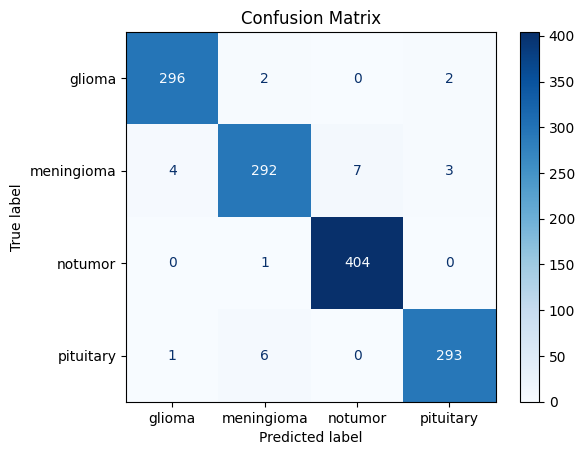

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model):
    model.eval()  # Set to evaluation mode
    all_preds = []
    all_labels = []
    
    # Disable gradient computation
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Collect predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate and display the confusion matrix
evaluate_model(model)
